In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
from datetime import date, timezone, timedelta
import pandas as pd
import numpy as np
import utils
import yfinance as yf
from spreads_prep import spreads_prep
from backtest import backtest
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import time
from datetimerange import DateTimeRange
import math
import gc
import os, glob

# Create option data by DTE

If you want to generate spreads on specific DTE that is not included in the preload folder, please see the section below for codes. Otherwise, skip to the next section. With Core-i9 and DDR5, the average process time for generate one dataset range from 120s to 300s depending on your DTE setting. It requres around 10GB of RAM. The generated CSV files will be saved under OptionsData

In [4]:
# tk = 'SPY'
# df_stock = utils.OHLC_info_by_range(tk,'2005-01-01','2023-12-31',interval = '1d')
# st = df_stock.copy()
# path = 'OptionsData\\'
# _op = list()

# for filename in glob.glob(os.path.join(path + tk, '*.csv')):
#     _op.append(pd.read_csv(filename))

[*********************100%***********************]  1 of 1 completed
Start date: 2005-01-01
End date: 2023-12-31


C:\Users\27270\AppData\Local\Temp\ipykernel_29704\1587516934.py:8: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  _op.append(pd.read_csv(filename))
C:\Users\27270\AppData\Local\Temp\ipykernel_29704\1587516934.py:8: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  _op.append(pd.read_csv(filename))
C:\Users\27270\AppData\Local\Temp\ipykernel_29704\1587516934.py:8: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  _op.append(pd.read_csv(filename))
C:\Users\27270\AppData\Local\Temp\ipykernel_29704\1587516934.py:8: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  _op.append(pd.read_csv(filename))
C:\Users\27270\AppData\Local\Temp\ipykernel_29704\1587516934.py:8: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  _op.append(pd.

C:\Users\27270\AppData\Local\Temp\ipykernel_29704\1587516934.py:8: DtypeWarning: Columns (12,16) have mixed types. Specify dtype option on import or set low_memory=False.
  _op.append(pd.read_csv(filename))
C:\Users\27270\AppData\Local\Temp\ipykernel_29704\1587516934.py:8: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  _op.append(pd.read_csv(filename))
C:\Users\27270\AppData\Local\Temp\ipykernel_29704\1587516934.py:8: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  _op.append(pd.read_csv(filename))
C:\Users\27270\AppData\Local\Temp\ipykernel_29704\1587516934.py:8: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  _op.append(pd.read_csv(filename))


In [5]:
# op = pd.concat(_op, ignore_index = True)
# class_prep = spreads_prep(op,st,DTE = list(range(45,120)))

Done Cleaning Data! CPU time: 23.50 seconds, Total time: 55.26 seconds
Done Calculating Probability! CPU time: 2.50 seconds, Total time: 5.94 seconds
Done Calculating Spreads with DTE = 45! CPU time: 166.20 seconds, Total time: 352.14 seconds
Done Calculating Spreads with DTE = 46! CPU time: 135.73 seconds, Total time: 306.43 seconds
Done Calculating Spreads with DTE = 47! CPU time: 6.77 seconds, Total time: 15.74 seconds
Done Calculating Spreads with DTE = 48! CPU time: 13.88 seconds, Total time: 35.67 seconds
Done Calculating Spreads with DTE = 49! CPU time: 152.17 seconds, Total time: 334.66 seconds
Done Calculating Spreads with DTE = 50! CPU time: 134.34 seconds, Total time: 299.07 seconds
Done Calculating Spreads with DTE = 51! CPU time: 119.19 seconds, Total time: 270.18 seconds
Done Calculating Spreads with DTE = 52! CPU time: 117.16 seconds, Total time: 269.26 seconds
Done Calculating Spreads with DTE = 53! CPU time: 110.73 seconds, Total time: 249.64 seconds
Done Calculating S

# Use preloaded spread data

In [3]:
op_cols = ['Symbol','QuoteDate', 'ExpirationDate', 'SellPrice', 'BuyPrice', 'Dte',
       'SellStrike', 'BuyStrike','UnderlyingPrice', 'Premium', 'MaxLoss', 'Sell_OTM_Prob', 'ExpectedEarnRatio', 'ExpectedEarn', 'Actual_Earn']
op_greeks = ['ImpliedVolatility', 'Delta','Gamma', 'Vega', 'Rho', 'Theta']

tk = 'SPY' #<-------- Set ticker symbol here
df_stock = utils.OHLC_info_by_range(tk,'2005-01-01','2023-12-31',interval = '1d')
st = df_stock.copy()

[*********************100%***********************]  1 of 1 completed
Start date: 2005-01-01
End date: 2023-12-31


In [4]:
path = 'SpreadsData\\'
spread_type = 'Put' 
DTE = 14  #<-------- Set DTE here 
_sp = list()

for i in range(1,DTE+1):
    filename = path+ tk + '\\DTE' + str(i) + '_' + tk + '_' + spread_type + 'Spreads.csv'
    _sp.append(pd.read_csv(filename, index_col = 0))
# for filename in glob.glob(os.path.join(path + tk, '*.csv')):
#     _sp.append(pd.read_csv(filename))
spreads = pd.concat(_sp, ignore_index = True)
spreads['Symbol'] = tk

## Initialize and find best parameters

In [6]:
# Initialize
backtest_test = backtest(_spread_data = spreads, _DTE = DTE, _stock_data = st)
backtest_test.all_spreads.shape

Done initializing! Time: 56.23 seconds.


(30605527, 30)

In [23]:
'''
This part is for testing optimal expected OTM prob settings
You can define your desire spread width below in this block to check ROI in different OTM prob settings
'''

exp_win = [round(0.05 * i,2) for i in range(0,21)]
actual_win = list()
number_of_spreads = list()
average_profit = list()
cc = 0
while cc < len(exp_win)-1:
    def parms():
        min_Expected_Earn = None
        min_Expected_Earn_Ratio = None

        Sell_OTM_Prob_Range = [exp_win[cc], exp_win[cc+1]]
        Buy_OTM_Prob_Range = [exp_win[cc+1],None]

        min_Width = 2
        max_Width = 2

        max_trades_per_day = 1

        min_Premium = None
        max_Distance_to_Strike_Ratio = None

        Skip_Date = ['2018-2-9']

        parm = (min_Expected_Earn,min_Expected_Earn_Ratio,Sell_OTM_Prob_Range,Buy_OTM_Prob_Range,
                min_Width,max_Width,max_trades_per_day,min_Premium,max_Distance_to_Strike_Ratio,Skip_Date)

        print(Sell_OTM_Prob_Range)
        return parm
    
    
    backtest_test.set_parm(parms())
    backtest_test.find_spreads(_start_date = '2015-01-01', _end_date = None, 
                                                  _use_technical_indicator = False, _min_iv_ratio = None)
    filtered_spreads = backtest_test.spreads_satisfied
    number_of_spreads.append(len(filtered_spreads))
    actual_win.append(round( (filtered_spreads.Actual_Earn > 0).sum()/len(filtered_spreads),4))
    average_profit.append(round((filtered_spreads.Actual_Earn/ 
                                 abs(filtered_spreads.SellStrike - filtered_spreads.BuyStrike)).sum()/
                                len(filtered_spreads),2 ))
    cc += 1
    

[0.0, 0.05]
Done searching spreads from 2015-01-01 00:00:00 to 2023-01-13 00:00:00!
Total Time: 1.71 seconds, CPU Time: 0.62 seconds.
[0.05, 0.1]
Done searching spreads from 2015-01-01 00:00:00 to 2023-01-13 00:00:00!
Total Time: 4.34 seconds, CPU Time: 0.92 seconds.
[0.1, 0.15]
Done searching spreads from 2015-01-01 00:00:00 to 2023-01-13 00:00:00!
Total Time: 1.63 seconds, CPU Time: 0.28 seconds.
[0.15, 0.2]
Done searching spreads from 2015-01-01 00:00:00 to 2023-01-13 00:00:00!
Total Time: 1.62 seconds, CPU Time: 0.28 seconds.
[0.2, 0.25]
Done searching spreads from 2015-01-01 00:00:00 to 2023-01-13 00:00:00!
Total Time: 1.62 seconds, CPU Time: 0.44 seconds.
[0.25, 0.3]
Done searching spreads from 2015-01-01 00:00:00 to 2023-01-13 00:00:00!
Total Time: 1.65 seconds, CPU Time: 0.39 seconds.
[0.3, 0.35]
Done searching spreads from 2015-01-01 00:00:00 to 2023-01-13 00:00:00!
Total Time: 1.6 seconds, CPU Time: 0.42 seconds.
[0.35, 0.4]
Done searching spreads from 2015-01-01 00:00:00 to 

C:\Users\27270\AppData\Local\Temp\ipykernel_5600\2656030749.py:41: RuntimeWarning: invalid value encountered in scalar divide
  actual_win.append(round( (filtered_spreads.Actual_Earn > 0).sum()/len(filtered_spreads),4))
C:\Users\27270\AppData\Local\Temp\ipykernel_5600\2656030749.py:42: RuntimeWarning: invalid value encountered in scalar divide
  average_profit.append(round((filtered_spreads.Actual_Earn/


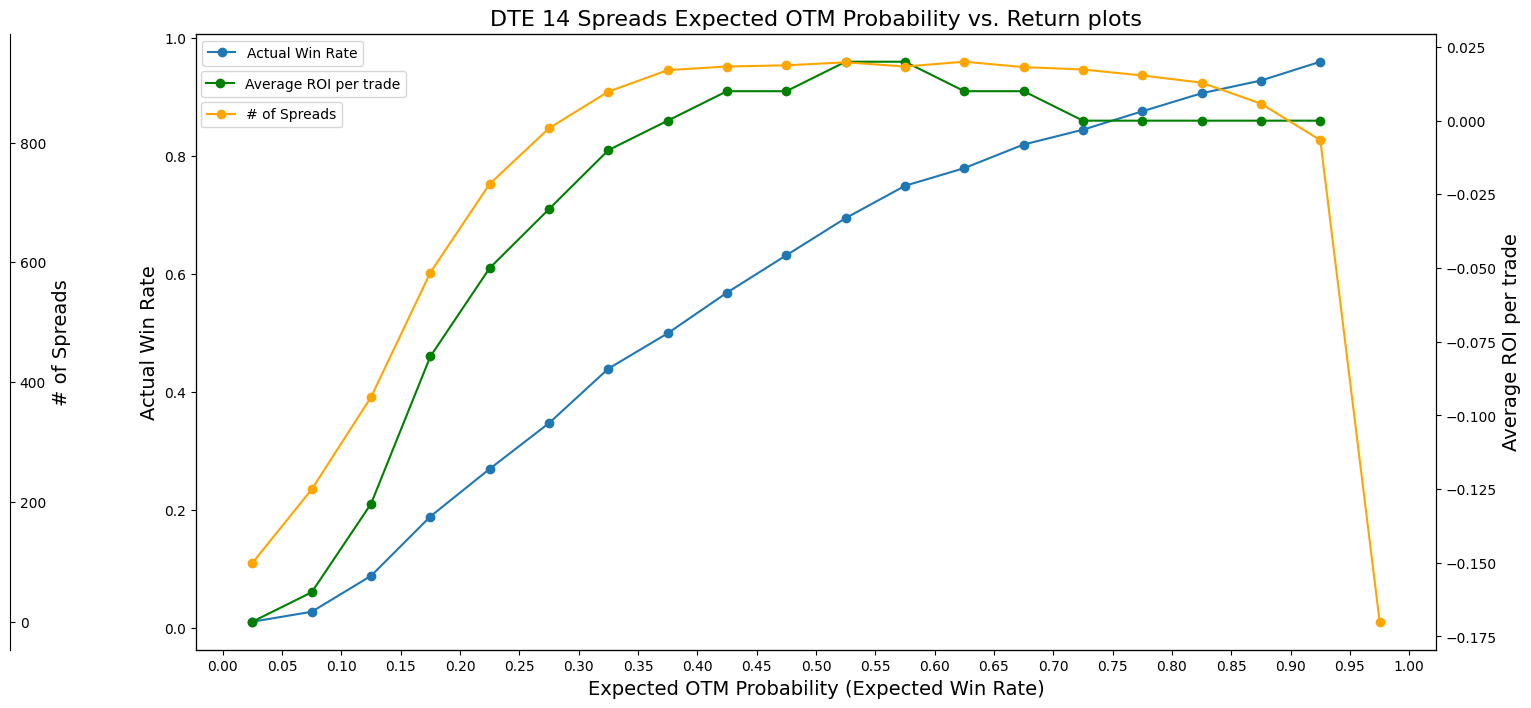

In [11]:
# Plot the result
fig,ax1 = plt.subplots()
fig.set_size_inches(16, 8, forward=True)

plot_x = [round(i+0.025,3) for i in exp_win]
plot_x.pop(-1)

ax1.plot(plot_x, actual_win, label = 'Actual Win Rate',marker='o')
ax1.set_xticks(exp_win)
ax1.set_xlabel("Expected OTM Probability (Expected Win Rate)", fontsize = 14)
ax1.set_ylabel("Actual Win Rate", color="black", fontsize=14)


# make a plot with different y-axis using second axis object
ax2 = ax1.twinx()

ax2.plot(plot_x, average_profit, label = 'Average ROI per trade', color = 'green',marker='o')
ax2.set_ylabel("Average ROI per trade", color="black", fontsize=14)

ax3 = ax1.twinx()
ax3.plot(plot_x, number_of_spreads, label = '# of Spreads', color = 'orange',marker='o')
ax3.set_ylabel("# of Spreads", color="black", fontsize=14)
ax3.spines['right'].set_position(('axes',-0.15))

ax1.legend(bbox_to_anchor=(0.14,1))
ax2.legend(bbox_to_anchor=(0.175,0.95))
ax3.legend(bbox_to_anchor=(0.123,0.9))

plt.title('DTE ' + str(DTE) +' Spreads Expected OTM Probability vs. Return plots', fontsize=16)
plt.show()

- From the plot above, seems like we need to set Expected OTM to be > 0.55 to achieve a greater than 75% actual win rate.

## Set parameters and filter spreads for back testing

- Spread searching is fairly quick, you can test different parms settings and check the number of spreads found and their win rate 
- Use **backtest.spreads_satisfied** to access the spreads founds

In [24]:
# Change the following parameters to create a filtering strategy.
def parms():
    min_Expected_Earn = None
    min_Expected_Earn_Ratio = 0 #<------ Enforce it to be > 0 to make only positive expectation trades.
    
    Sell_OTM_Prob_Range = [0.75,None] #<----- Setting desire expected OTM probability
    Buy_OTM_Prob_Range = [0.8,None]
    
    min_Width = 2 #<----- Setting the desire spread width
    max_Width = 2
    
    max_trades_per_day = 1
    
    min_Premium = None
    max_Distance_to_Strike_Ratio = None
    
    Skip_Date = ['2018-2-9']
    
    parm = (min_Expected_Earn,min_Expected_Earn_Ratio,Sell_OTM_Prob_Range,Buy_OTM_Prob_Range,
            min_Width,max_Width,max_trades_per_day,min_Premium,max_Distance_to_Strike_Ratio,Skip_Date)
    
    return parm

In [25]:
backtest_test.set_parm(parms())
backtest_test.find_spreads(_start_date = '2015-01-01', _end_date = None, _use_technical_indicator = False, _min_iv_ratio = None)
backtest_test.spreads_satisfied[op_cols]

print('Expected Win Rate:')
print(round(np.mean(backtest_test.spreads_satisfied.Sell_OTM_Prob),4))
print('Actual Win Rate:')
backtest_test.win_rate()

Done searching spreads from 2015-01-01 00:00:00 to 2023-01-13 00:00:00!
Total Time: 1.63 seconds, CPU Time: 0.22 seconds.
Expected Win Rate:
0.992
Actual Win Rate:
Total: 591 satisfied spreads, win rate: 0.9915


0.9915

In [29]:
backtest_test.spreads_satisfied[op_cols].head(10)

,Symbol,QuoteDate,ExpirationDate,SellPrice,BuyPrice,Dte,SellStrike,BuyStrike,UnderlyingPrice,Premium,MaxLoss,Sell_OTM_Prob,ExpectedEarnRatio,ExpectedEarn,Actual_Earn
2074138,SPY,2015-01-02,2015-01-16,0.18,0.17,14,186.5,184.5,204.96,0.01,1.99,0.996203,0.001203,0.002405,0.01
2189605,SPY,2015-02-13,2015-02-27,0.16,0.13,14,198.0,196.0,209.80,0.03,1.97,0.985485,0.000485,0.000970,0.03
2203479,SPY,2015-02-20,2015-03-06,0.10,0.09,14,195.0,193.0,211.21,0.01,1.99,0.998734,0.003734,0.007468,0.01
2216770,SPY,2015-02-27,2015-03-13,0.09,0.08,14,197.0,195.0,211.02,0.01,1.99,0.997309,0.002309,0.004617,0.01
2348122,SPY,2015-04-24,2015-05-08,0.08,0.07,14,198.0,196.0,211.69,0.01,1.99,0.995140,0.000140,0.000280,0.01
2362092,SPY,2015-05-01,2015-05-15,0.07,0.06,14,195.0,193.0,210.72,0.01,1.99,0.995315,0.000315,0.000629,0.01
2384047,SPY,2015-05-08,2015-05-22,0.09,0.08,14,198.0,196.0,211.36,0.01,1.99,0.995188,0.000188,0.000375,0.01
2401604,SPY,2015-05-15,2015-05-29,0.09,0.08,14,199.0,197.0,212.45,0.01,1.99,0.997045,0.002045,0.004090,0.01
2414608,SPY,2015-05-22,2015-06-05,0.07,0.06,14,200.0,198.0,213.02,0.01,1.99,0.996756,0.001756,0.003512,0.01
2468096,SPY,2015-06-16,2015-06-30,0.08,0.07,14,189.0,187.0,210.37,0.01,1.99,0.995635,0.000635,0.001271,0.01


## Set porfolio and backtest


- Running time for each backtest will be around 5-10 min based on DTE

In [30]:
def define_portfolio():
    funds = 10000 
    take_profit = None
    stop_loss = 3 #<-------------- Set your stop loss here
    position_size = 0.3 #<--------------  Maximun funds allocated for each trade 
    max_position = 0.7 #<-------------- Maximun total funds allocated at any time
    
    return (funds, take_profit, stop_loss, position_size, max_position)


backtest_test.set_portfolio(define_portfolio(), _backtest_start_date = None , _backtest_end_date = None)

Done Done Preparing for Backtesting 681.37 seconds
Done backtesting: 682.75 seconds
Year 2015 Return: 15.0 Starting: 10000
Year 2016 Return: 150.0 Starting: 10015.0
Year 2017 Return: 193.0 Starting: 10165.0
Year 2018 Return: 181.0 Starting: 10358.0
Year 2019 Return: 314.0 Starting: 10539.0
Year 2020 Return: 386.0 Starting: 10853.0
Year 2021 Return: 394.0 Starting: 11239.0
Year 2022 Return: 68.0 Starting: 11633.0
Annual return rate: [0.0015, 0.015, 0.019, 0.0175, 0.0298, 0.0356, 0.0351, 0.0058]
Annual return std: 0.01195558838995388
Report:

Number of Positions: 589
Win Rate: 0.8472
Sharpe Ratio: 1.67
Total Return: 1701.0
Total Return Ratio: 0.1701
Funds not utilized: 8134.0
Max Collateral: 1000.0
Max Drawdown: 0.011 Date: 2021-11-29 00:00:00 - 2022-02-11 00:00:00
Max Individual Loss: -48.0 id: 21915810
Max Individual Gain: 108.0 id: 6544972
Average Collateral: 454.67
Average Gain: 2.89
Average Annual Return: 0.02
Average Return Ratio: 0.0067
Average Expectation Return Ratio: 0.0046
Ave

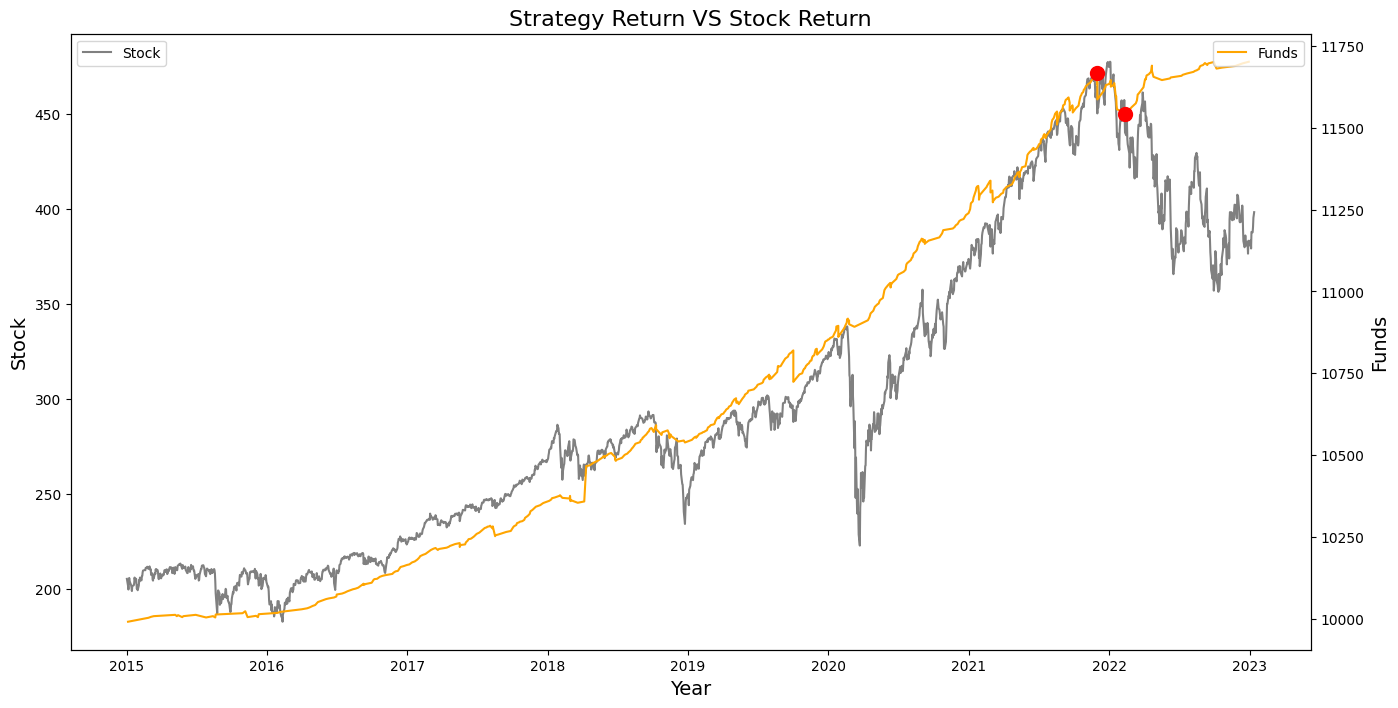

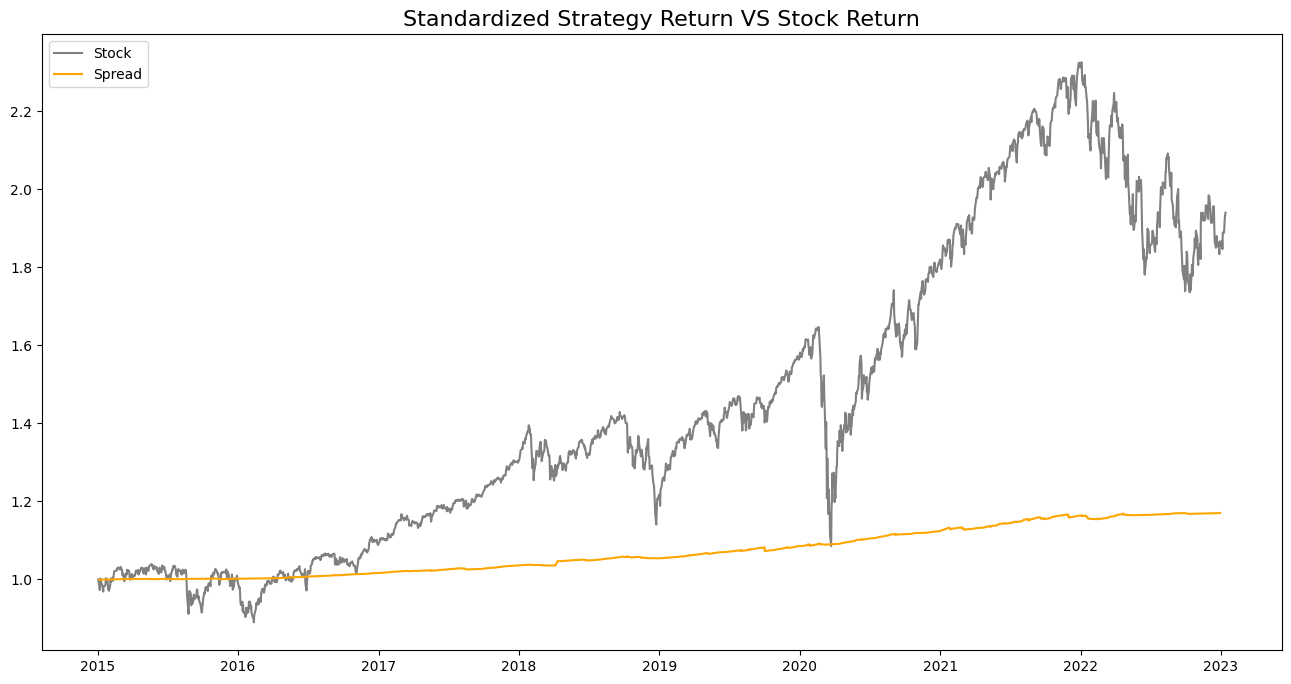

In [32]:
backtest_test.generate_results()
backtest_test.report()

In [28]:
# Display Trade history
trades_history = backtest_test.trades_history
trades_history.style.set_properties(subset=['Option Info: ((Sell Strike, buy Strike, Expiry), Quantity, Collateral, Premium, idx)'], **{'width': '300px'})

,Date,Spreads Type,Spread index,Trades Type,Initial Funds,Funds After,Stock Price,"Option Info: ((Sell Strike, buy Strike, Expiry), Quantity, Collateral, Premium, idx)",Profit,# of strategies holding
0,2015-01-23 00:00:00,P,4101472,Open,10000.000000,7000.000000,204.970000,"((185.0, 183.0, Timestamp('2015-02-20 00:00:00')), 15, 3000.0, 0.04, 4101472)",0.000000,1
1,2015-02-20 00:00:00,P,4234048,Open,7000.000000,5000.000000,211.240000,"((181.0, 179.0, Timestamp('2015-03-20 00:00:00')), 10, 2000.0, 0.01, 4234048)",0.000000,2
2,2015-02-20 00:00:00,P,4101472,Close,5000.000000,8060.000000,211.240000,"((185.0, 183.0, Timestamp('2015-02-20 00:00:00')), 15, 3000.0, 0.04, 4101472)",60.000000,1
3,2015-03-03 00:00:00,P,4293143,Open,8060.000000,5660.000000,211.120000,"((187.0, 185.0, Timestamp('2015-03-31 00:00:00')), 12, 2400.0, 0.02, 4293143)",0.000000,2
4,2015-03-20 00:00:00,P,4234048,Close,5660.000000,7670.000000,210.410000,"((181.0, 179.0, Timestamp('2015-03-20 00:00:00')), 10, 2000.0, 0.01, 4234048)",10.000000,1
5,2015-03-31 00:00:00,P,4293143,Close,7670.000000,10094.000000,206.430000,"((187.0, 185.0, Timestamp('2015-03-31 00:00:00')), 12, 2400.0, 0.02, 4293143)",24.000000,0
6,2015-04-17 00:00:00,P,4508828,Open,10094.000000,7094.000000,207.950000,"((188.0, 186.0, Timestamp('2015-05-15 00:00:00')), 15, 3000.0, 0.03, 4508828)",0.000000,1
7,2015-05-15 00:00:00,P,4508828,Close,7094.000000,10139.000000,212.440000,"((188.0, 186.0, Timestamp('2015-05-15 00:00:00')), 15, 3000.0, 0.03, 4508828)",45.000000,0
8,2015-05-22 00:00:00,P,4662498,Open,10139.000000,7139.000000,212.990000,"((185.0, 183.0, Timestamp('2015-06-19 00:00:00')), 15, 3000.0, 0.01, 4662498)",0.000000,1
9,2015-06-02 00:00:00,P,4705416,Open,7139.000000,5139.000000,211.360000,"((185.0, 183.0, Timestamp('2015-06-30 00:00:00')), 10, 2000.0, 0.01, 4705416)",0.000000,2


In [85]:
# trades_history.to_csv('saved_trades_history\\DTE7_trade_history_capped_stoploss.csv')

## ==================================================================
## Codes below are still under development 
## ==================================================================

## Results with both technical indicators and parameters

In [268]:
#initialize
backtest_class_with_TA = backtest(_spread_data = spreads, _DTE = DTE, _stock_data = st)

Done initializing! Time: 28.45 seconds.


In [298]:
backtest_class_with_TA.set_parm(parms())
backtest_class_with_TA.find_spreads(_use_technical_indicator = True, _min_iv_ratio = 0.8, _start_date = '2015-01-01')

print('Expected Win Rate:')
print(round(np.mean(backtest_class_with_TA.spreads_satisfied.Sell_OTM_Prob),4))
print('Actual Win Rate:')
backtest_class_with_TA.win_rate()

Done searching spreads from 2015-01-01 00:00:00 to 2023-01-06 00:00:00!
Total Time: 1.55 seconds, CPU Time: 0.31 seconds.
Total: 267 satisfied spreads, win rate: 0.9888


0.9888

In [299]:
backtest_class_with_TA.set_portfolio(define_portfolio(), _backtest_start_date = None , _backtest_end_date = None)
backtest_class_with_TA.generate_results()

Done Done Preparing for Backtesting 121.21 seconds
Done backtesting: 122.15 seconds


Year 2015 Return: -299.0000000000015 Starting: 10066.0
Year 2016 Return: -39.0 Starting: 9581.0
Year 2017 Return: 869.999999999997 Starting: 9719.0
Year 2018 Return: 851.9999999999972 Starting: 10636.999999999996
Year 2019 Return: 1260.9999999999973 Starting: 11551.999999999995
Year 2020 Return: 160.00000000000156 Starting: 12744.999999999993
Year 2021 Return: 5088.999999999994 Starting: 12384.999999999995
Year 2022 Return: 539.9999999999994 Starting: 18071.999999999993
[-0.0297, -0.0041, 0.0895, 0.0801, 0.1092, 0.0126, 0.4109, 0.0299]
std: 0.13046602048043007
Report:

Number of Positions: 156
Win Rate: 0.8718
Sharpe Ratio: 0.67
Total Return: 8434.0
Total Return Ratio: 0.8434
Funds not utilized: 1.999999999994543
Max Collateral: 18300.0
Max Drawdown: 0.084 Date: 2020-02-27 00:00:00
Max Individual Loss: -804.0 id: 1167367
Max Individual Gain: 351.0 id: 5184583
Average Collateral: 9515.06
Average Gain: 54.06
Average Annual Return: 0.09
Average Return Ratio: 0.0056
Average Expectation Ret

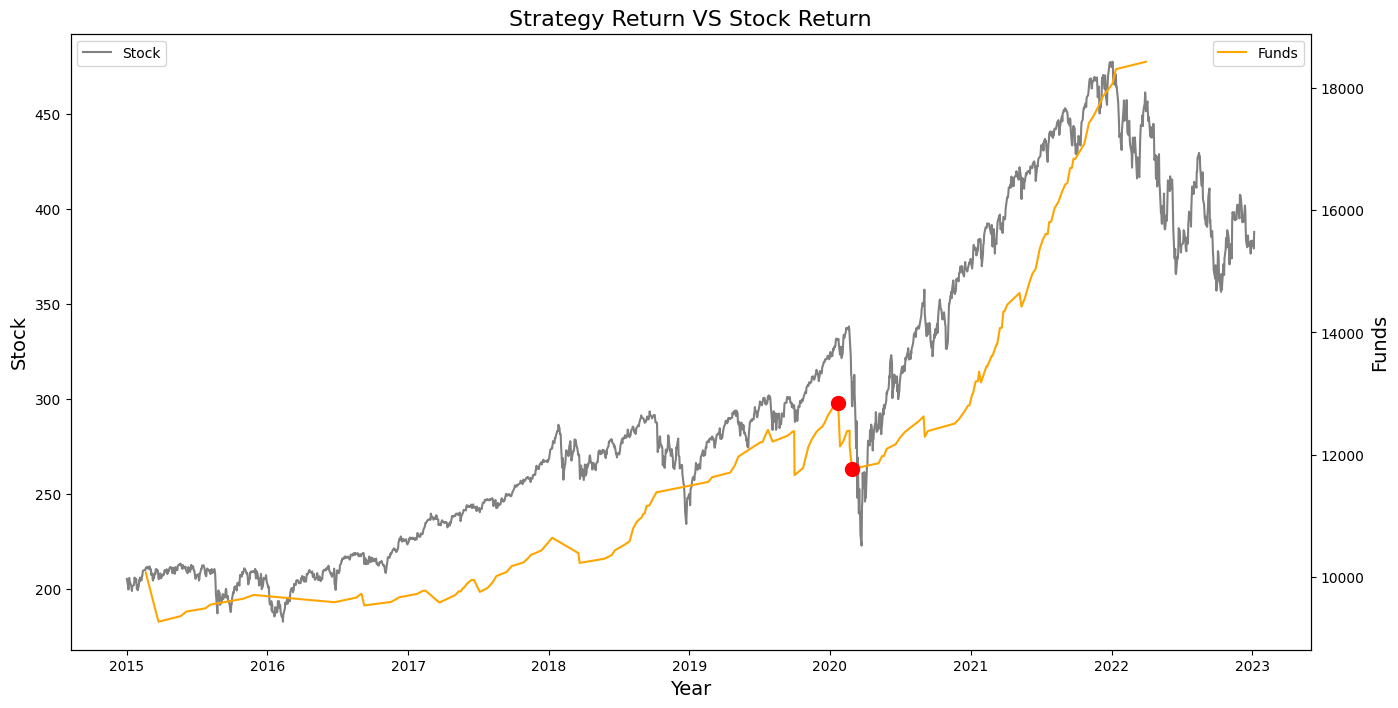

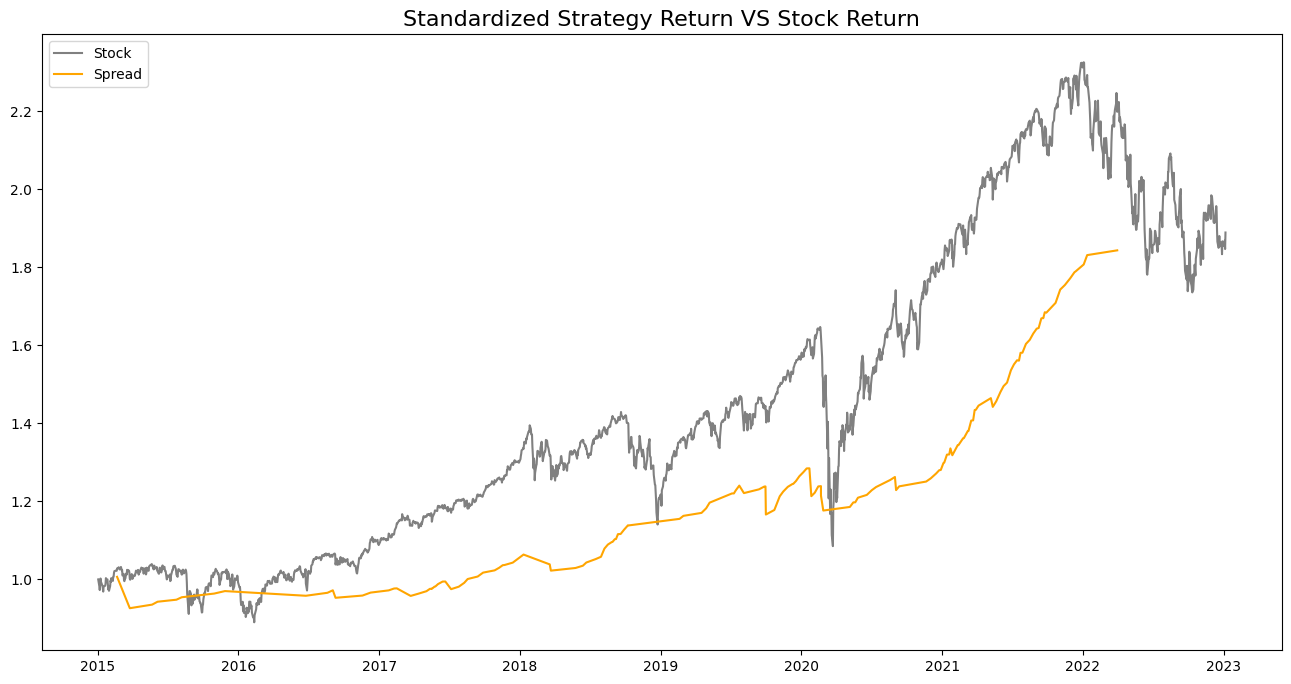

In [300]:
backtest_class_with_TA.report()

In [301]:
TA_trades_history = backtest_class_with_TA.trades_history
TA_trades_history.style.set_properties(subset=['Option Info: ((Sell Strike, buy Strike, Expiry), Quantity, Collateral, Premium, idx)'], **{'width': '300px'})

,Date,Spreads Type,Spread index,Trades Type,Initial Funds,Funds After,Stock Price,"Option Info: ((Sell Strike, buy Strike, Expiry), Quantity, Collateral, Premium, idx)",Profit,# of strategies holding
0,2015-02-13 00:00:00,P,1122685,Open,10000.000000,100.000000,209.780000,"((195.0, 193.5, Timestamp('2015-02-20 00:00:00')), 66, 9900.0, 0.0099999999999999, 1122685)",0.000000,1
1,2015-02-20 00:00:00,P,1122685,Close,100.000000,10066.000000,211.240000,"((195.0, 193.5, Timestamp('2015-02-20 00:00:00')), 66, 9900.0, 0.0099999999999999, 1122685)",66.000000,0
2,2015-03-20 00:00:00,P,1167367,Open,10066.000000,16.000000,210.410000,"((204.0, 203.5, Timestamp('2015-03-27 00:00:00')), 201, 10050.0, 0.02, 1167367)",0.000000,1
3,2015-03-25 00:00:00,P,1167367,Stop Loss,16.000000,9262.000000,205.760000,"((204.0, 203.5, Timestamp('2015-03-27 00:00:00')), 201, 10050.0, 0.02, 1167367)",-804.000000,0
4,2015-05-15 00:00:00,P,1226048,Open,9262.000000,62.000000,212.440000,"((199.5, 198.5, Timestamp('2015-05-22 00:00:00')), 92, 9200.0, 0.01, 1226048)",0.000000,1
5,2015-05-22 00:00:00,P,1226048,Close,62.000000,9354.000000,212.990000,"((199.5, 198.5, Timestamp('2015-05-22 00:00:00')), 92, 9200.0, 0.01, 1226048)",92.000000,0
6,2015-05-29 00:00:00,P,1237707,Open,9354.000000,104.000000,211.140000,"((198.5, 196.0, Timestamp('2015-06-05 00:00:00')), 37, 9250.0, 0.0199999999999999, 1237707)",0.000000,1
7,2015-06-05 00:00:00,P,1237707,Close,104.000000,9428.000000,209.770000,"((198.5, 196.0, Timestamp('2015-06-05 00:00:00')), 37, 9250.0, 0.0199999999999999, 1237707)",74.000000,0
8,2015-07-17 00:00:00,P,1302381,Open,9428.000000,328.000000,212.480000,"((203.0, 199.5, Timestamp('2015-07-24 00:00:00')), 26, 9100.0, 0.02, 1302381)",0.000000,1
9,2015-07-24 00:00:00,P,1302381,Close,328.000000,9480.000000,208.000000,"((203.0, 199.5, Timestamp('2015-07-24 00:00:00')), 26, 9100.0, 0.02, 1302381)",52.000000,0


## Some interesting plots

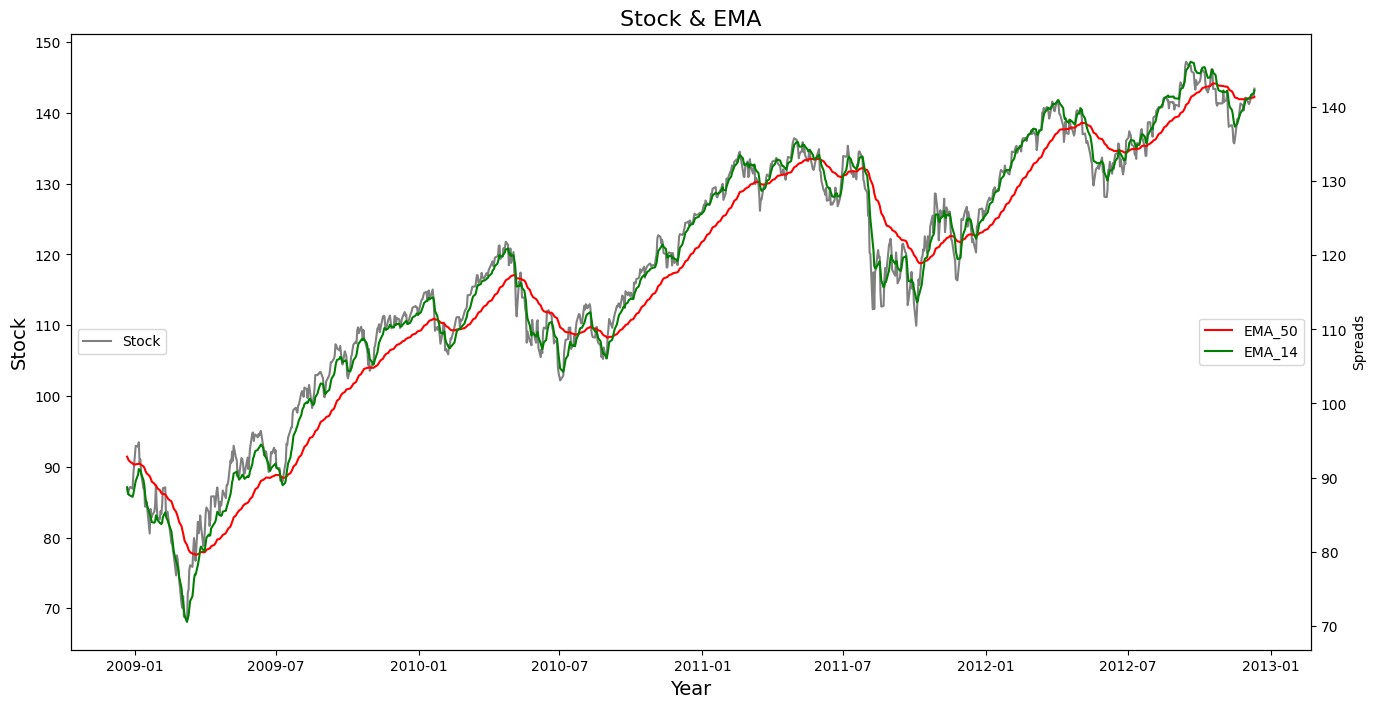

In [281]:
class_st = backtest_class_with_TA.stock_data
class_st = class_st[1000:2000]
fig,ax1 = plt.subplots()

fig.set_size_inches(16, 8, forward=True)
# make a plot
ax1.plot(class_st.Date, class_st.Close,color="grey")
# set x-axis label
ax1.set_xlabel("Year", fontsize = 14)
# set y-axis label
ax1.set_ylabel("Stock",
              color="black",
              fontsize=14)


# make a plot with different y-axis using second axis object
ax2 = ax1.twinx()
ax2.plot(class_st.dropna().Date, class_st.dropna().EMA_50,color="red")
ax2.plot(class_st.dropna().Date, class_st.dropna().EMA_DTE,color="green")
ax2.set_ylabel("Spreads",color="black")
plt.title("Stock & EMA",fontsize=16)
ax1.legend(['Stock'],loc='center left')
ax2.legend(['EMA_50', 'EMA_14'],loc='center right')

plt.show()

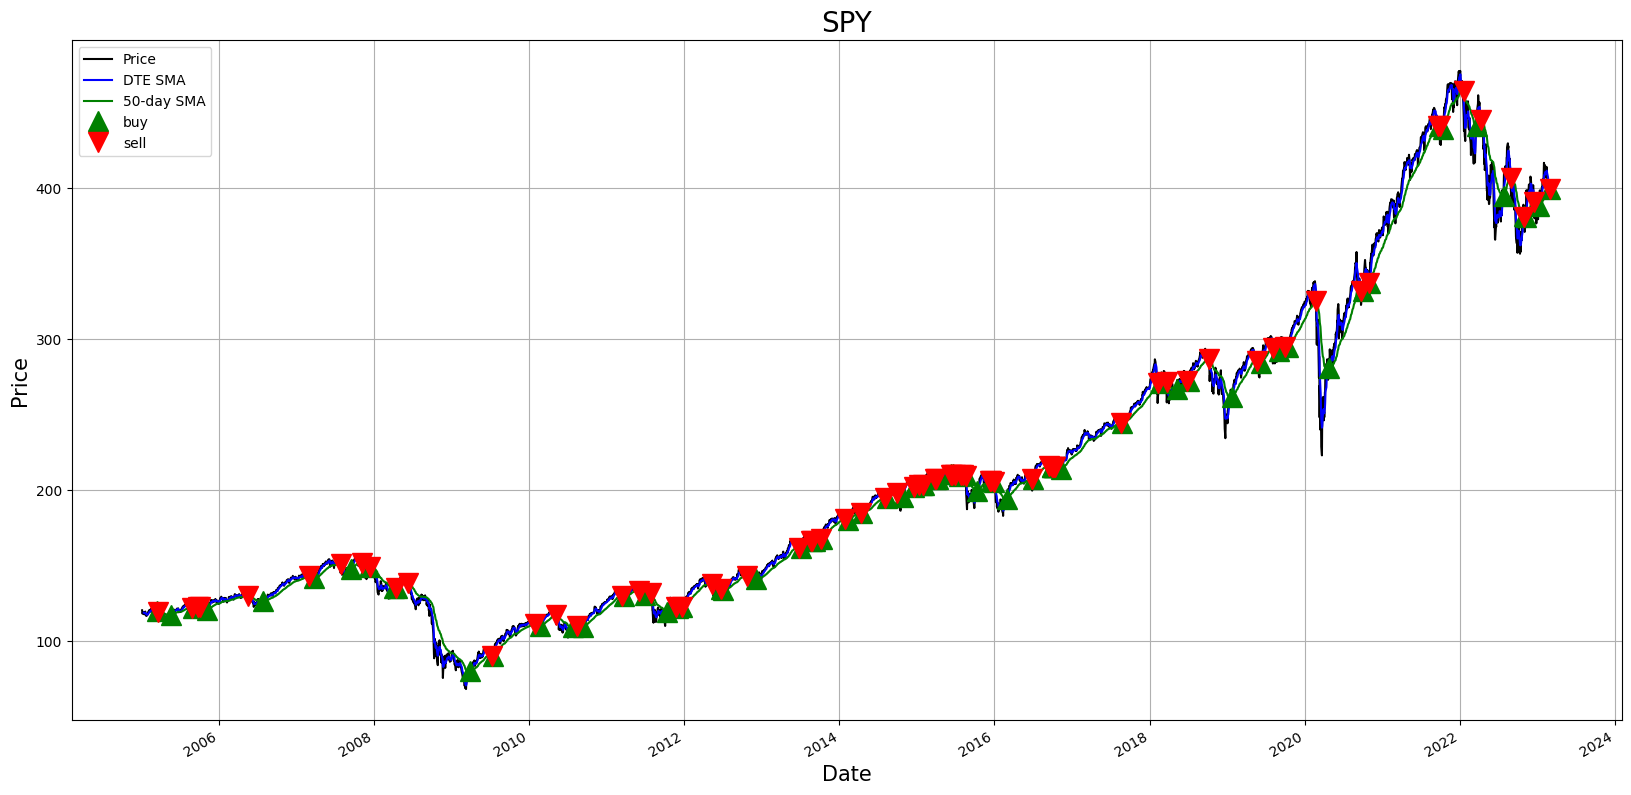

In [284]:
# Crossover plot

df_ = backtest_class_with_TA.stock_data

df_.index = df_.Date
plt.figure(figsize = (20,10))
# plot close price, short-term and long-term moving averages 
df_['Close'].plot(color = 'k', label= 'Price') 
df_['EMA_DTE'].plot(color = 'b',label = 'DTE SMA') 
df_['EMA_50'].plot(color = 'g', label = '50-day SMA')
# plot ‘buy’ signals
plt.plot(df_[df_['Trend_Reversal'] == 1].index, 
         df_['EMA_50'][df_['Trend_Reversal'] == 1], 
         '^', markersize = 15, color = 'g', label = 'buy')
# plot ‘sell’ signals
plt.plot(df_[df_['Trend_Reversal'] == -1].index, 
         df_['EMA_50'][df_['Trend_Reversal'] == -1], 
         'v', markersize = 15, color = 'r', label = 'sell')
plt.ylabel('Price', fontsize = 15 )
plt.xlabel('Date', fontsize = 15 )
plt.title('SPY', fontsize = 20)
plt.legend()
plt.grid()
plt.show()

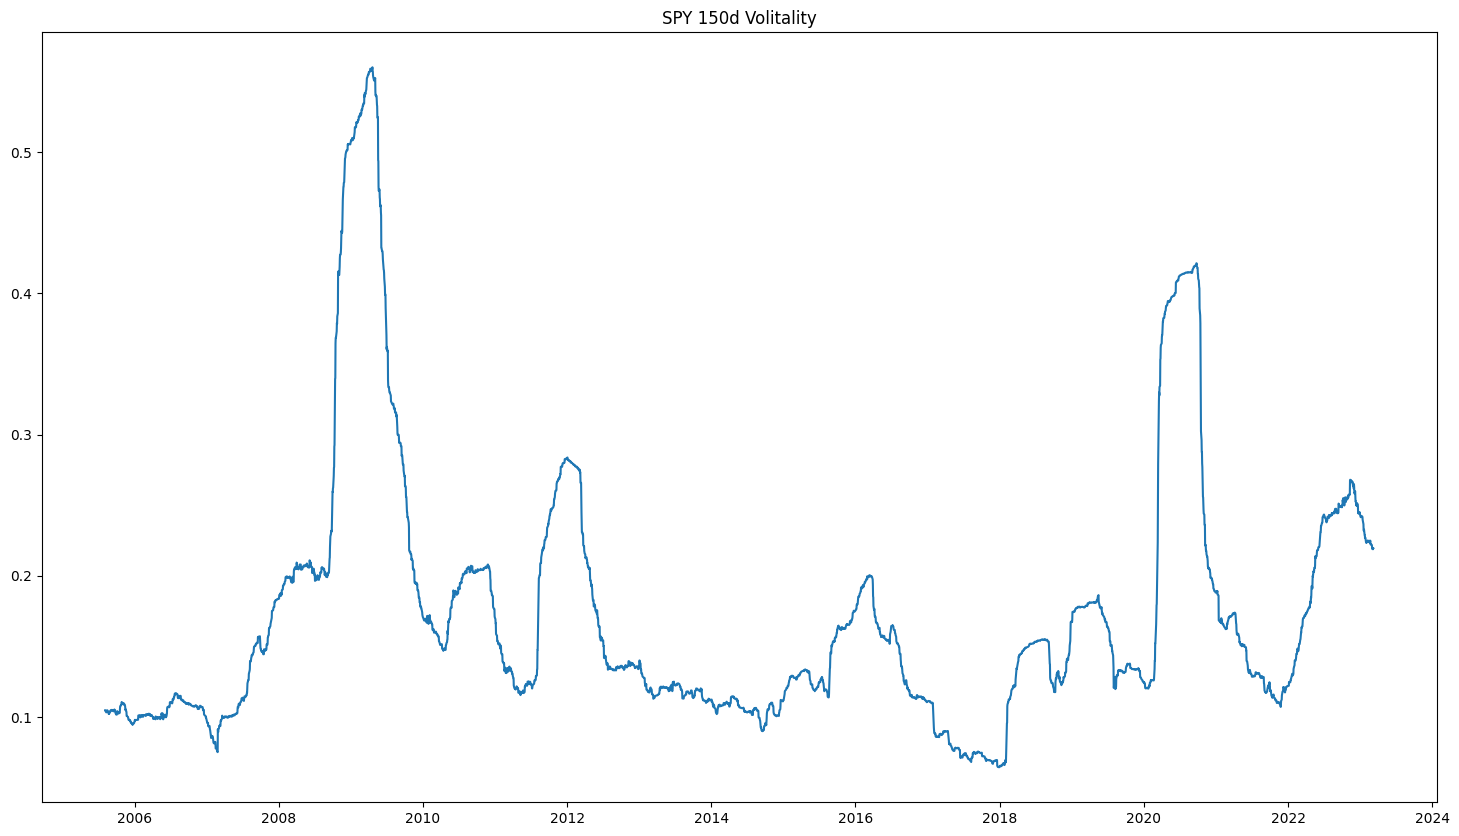

In [285]:
plt.figure(figsize = (18,10))
plt.title('SPY 150d Volitality')
plt.plot(backtest_class_with_TA.stock_data.Date, backtest_class_with_TA.stock_data.Hist_Volatility)

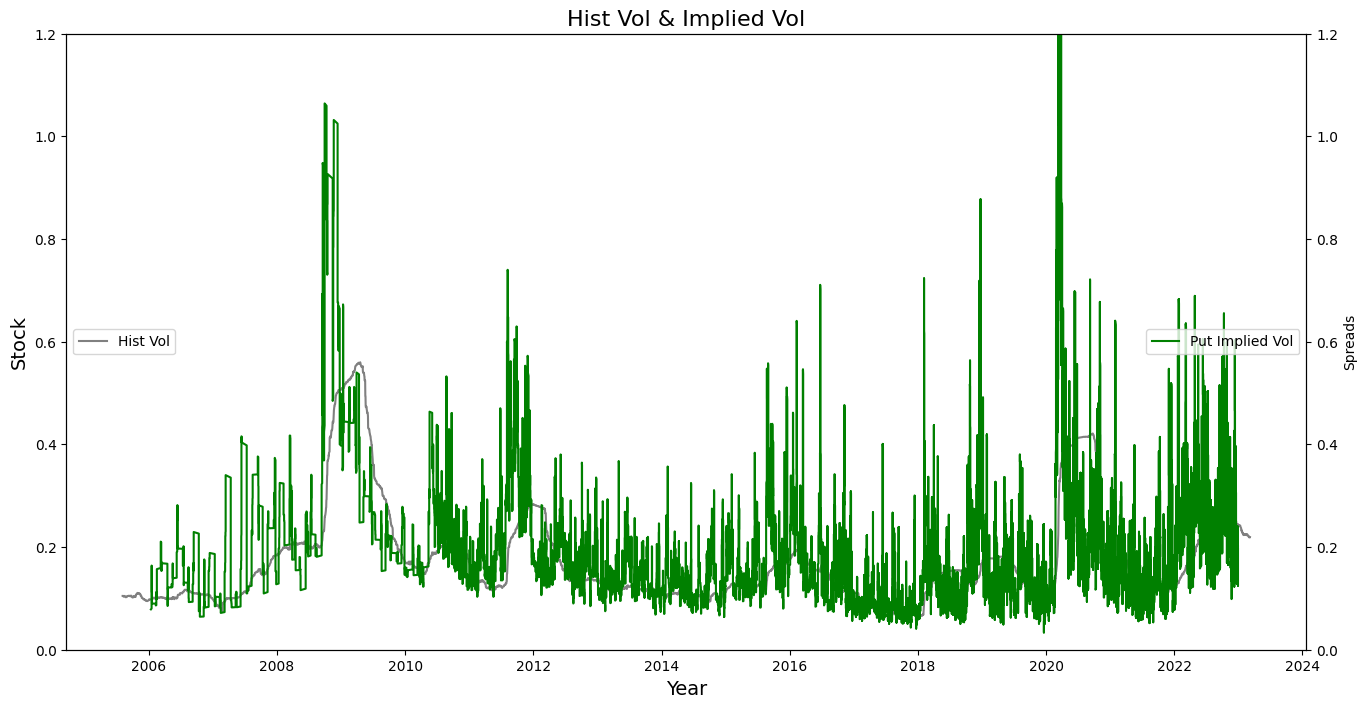

In [297]:
class_st = backtest_class_with_TA.stock_data
putt_ = backtest_class_with_TA.all_spreads
fig,ax1 = plt.subplots()

fig.set_size_inches(16, 8, forward=True)
# make a plot
ax1.plot(class_st.Date, class_st.Hist_Volatility,color="grey")
# set x-axis label
ax1.set_xlabel("Year", fontsize = 14)
# set y-axis label
ax1.set_ylabel("Stock",
              color="black",
              fontsize=14)
# ax1.set_yticks([0.05* i for i in range(10)])

# make a plot with different y-axis using second axis object
ax2 = ax1.twinx()

piv_avg7 = putt_.ATM_IV.rolling(50).mean() 

# ax2.plot(putt_.QUOTE_TIME_EST,piv_avg7,color="red")
ax2.plot(putt_.QuoteDate, piv_avg7,color="green")


ax2.set_ylabel("Spreads",color="black")
plt.title("Hist Vol & Implied Vol",fontsize=16)
ax1.legend(['Hist Vol'],loc='center left')
ax2.legend(['Put Implied Vol', 'Call Implied Vol'],loc='center right')

a,b = 0,1.2
ax1.set_ylim(a,b)
ax2.set_ylim(a,b)

plt.show()